<a href="https://colab.research.google.com/github/bpizarrogalleguillos/SOCHRADI-workshop/blob/master/BP-19-09-BoneAge_WorkShop_SOCHRADI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WorkShop de Inteligencia Artificial Congreso Chileno de Radiología 2022**


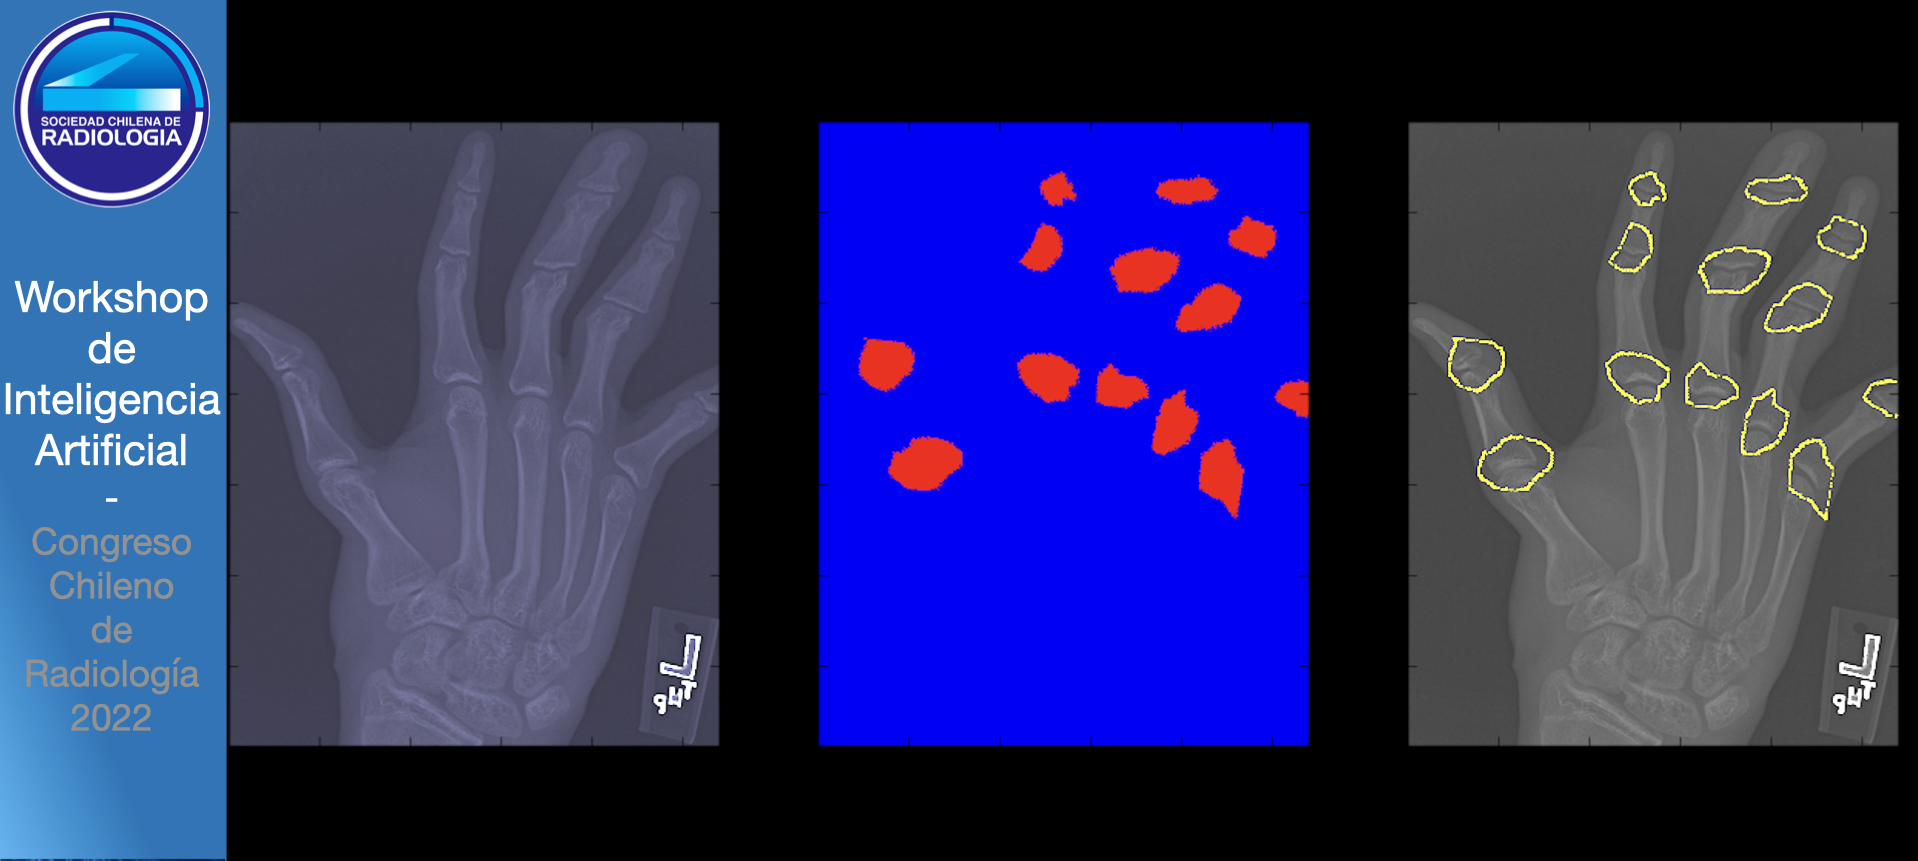

# Setting
Las siguientes líneas de código permiten importar las librerías, que en otras palabras corresponde a un conjunto de código con funciones determinadas que ya fueron realizados por otra persona y podemos volver a utilizar. 
También hay librerías que nos permiten entrenar modelos de machine learning, dos de los frameworks más utilizados son TensorFlow, Keras y PyTorch. Cada uno tiene sus ventajas y desventajas. Para este notebook en particular utilizaremos TensorFlow y Keras. Keras es más amigable es de alto nivel, lo que quiere decir que es más amigable para interactuar con humanos.

In [1]:
## Librerias generales de manejo de datos numéricos
import numpy as np # Esta libreria nos permite manejar "arrays"
import pandas as pd # Esta libreria nos permite manejar "dataframes"
import json # json es un formato de archivo
from sklearn.model_selection import train_test_split # sklearn es una librería para utilizar modelos de machine learning y funcionalidades asociadas
import statsmodels.api as sm # Libreria para utilizar herramientas estadísticas

## Librerías de visualización
import matplotlib.pyplot as plt 
from plotnine import*

## Librerias de keras para construcción y entrenamiento de Modelo Deep Learning

### Inception es un tipo de Red Neuronal
### Para saber más puedes ver este link https://paperswithcode.com/method/inception-v3
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input,concatenate

### Métodos de optimización de funciones
### Para saber más puedes ver este link https://velascoluis.medium.com/optimizadores-en-redes-neuronales-profundas-un-enfoque-pr%C3%A1ctico-819b39a3eb5
from tensorflow.keras.optimizers import SGD, RMSprop, Adam 

### MeanAbsoluteError es un tipo de funcion de pérdida 
### Para saber más puedes visitar este link https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1, l2

## Utilidades para ver advertencias y hacer solicitudes
import requests
import warnings
warnings.filterwarnings('ignore')

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.githubusercontent.com/HectorHenriquez/Bone-Age-WorkShop-Congreso/main/kaggle.json")
token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/traindata-boneage-challenge
!unzip /content/traindata-boneage-challenge.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 97% 331M/343M [00:03<00:00, 108MB/s] 
100% 343M/343M [00:03<00:00, 113MB/s]
Archive:  /content/traindata-boneage-challenge.zip
  inflating: tensorBoneAgeTrain160x200.npy  


# Análisis exploratorios
En las siguientes líneas de código, iremos realizando etapas sucesivas para entrenar nuestra red neuronal para predecir la edad en base a las radiografías y el género. 

In [2]:
## Carga de Tensor con imágenes
data = np.load('tensorBoneAgeTrain160x200.npy', allow_pickle=True)
print("Cantidad de imágenes:{},\nAncho de imágenes:{} pixeles, Alto de imágenes:{} pixeles".
      format(data.shape[0],data.shape[2],data.shape[1]))


Cantidad de imágenes:12611,
Ancho de imágenes:160 pixeles, Alto de imágenes:200 pixeles


## Visualización de las radiografías

Imagen: 1204


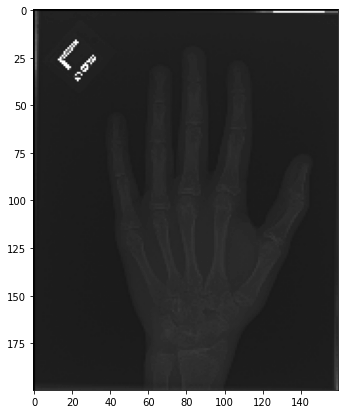

In [7]:
## Muestra aleatoria de las radiografías cargadas
 index = np.random.randint(0,data.shape[0])

### También puedes ver una imagen determinada, para esto elimina el "#" de la siguiente
### linea y escribe el número de la imagen que deseas visualizar 
# index = 1204

print('Imagen:', index)
plt.figure(figsize=(7,7))
plt.imshow(data[index,:,:], cmap='gray')
plt.show()

## Carga de datos clínicos y análisis de estos

In [11]:
## Carga de Data Clínica
### CSV es un tipo de archivo, muy similar a un Excel, donde cada columna esta delimitada por una coma. 
url = 'https://raw.githubusercontent.com/HectorHenriquez/Bone-Age-WorkShop-Congreso/main/TrainDataBoneAgeChallenge.csv'

### Cargamos la información como un "data frame" usando la librería pandas
dataClinica = pd.read_csv(url) 

## Previsualización de tabla de datos:
### head es un método del objeto "data frame" que nos permite visualizar los primeros valores de un dataframe 
### Si deseas ver más valores solo debes cambiar el número dentro del paréntesis
dataClinica.head(6) 

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
5,1382,138,True


Antes de realizar un análisis e implementar las redes neuronales u otras técnicas es importante conocer los datos por lo cuál siempre es recomendable
realizar un análisis exploratorio de los datos

Promedio de edad: 3.87 años



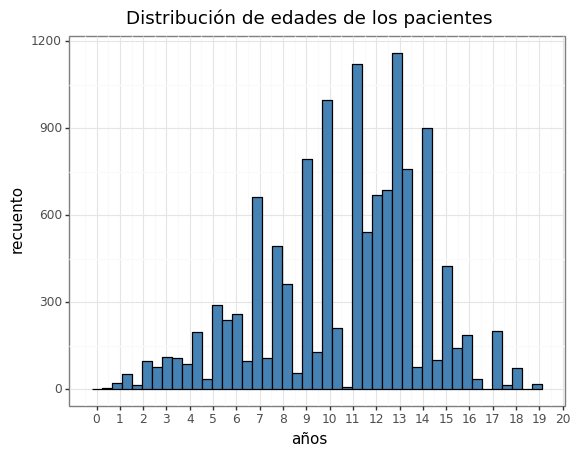

<ggplot: (8771325894141)>

In [12]:
## Análisis exploratorio:

## Edades
print("Promedio de edad: {} años\n".format(round(data.mean()/12,2)))
(ggplot(dataClinica) + aes(x='boneage/12') + 
 geom_histogram(fill='steelblue', color='black') +
 theme_bw() +
 labs(title='Distribución de edades de los pacientes', x='años', y='recuento')+
 scale_x_continuous(breaks=list(range(0,21,1)))
)

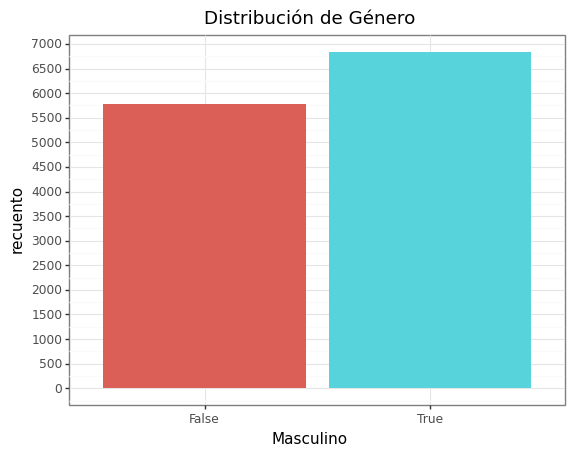

<ggplot: (8771323142089)>

In [13]:
## Género
(
    ggplot(dataClinica)+
 aes(x='male', fill='male') +
 geom_bar(show_legend=False) + 
 theme_bw() +
 labs(title='Distribución de Género', y='recuento', x = 'Masculino' ) +
    scale_y_continuous(breaks=list(range(0,7500,500)))

)

# Preparando el dataset para el entrenamiento y el testeo de la red neuronal
Es una etapa muy importante (Y casi obligatorio) separar el conjunto de los datos con los que se cuenta en datos de entrenamiento y datos de testeo. El ideal de esto es evitar que los modelos se sobreajusten a los datos. Lo anterior es importante porque lo que queremos lograr es que nuestro modelo no solo tenga un buen desempeño en un solo conjunto de datos dato si no que también en otros, es decir que "generalice" hacia otros datos. Para poner una analogía, si nuestro modelo tuviera un buen desempeño solo en el conjunto de entrenamiento, pero no en el testeo, es decir sobreajustado, sería como un estudiante que se aprende de memoria las respuestas de preguntas con la que estudia, pero que cuando llega la prueba no es capaz de responderla porque las preguntas cambiaron. 

A veces, también es frecuente ver que los datos se separan en un conjunto de validación, donde podemos optimizar algunos parámetros que definen la red u otros modelos de machine learning. Estos solamente pueden ser entrenados de forma "iterativa" sin poder determinarlos previamente, es decir simplemente es ensayo y error. En este tutorial, no realizaremos este paso por fines didácticos, pero es muy importante para mejorar la performance de los modelos en un proyecto.

In [15]:
## Separación aleatoria de conjuntos de entrenamiento y prueba

index = np.array(list(range(0,data.shape[0])))

## Uso de semilla para que todos podamos tener la misma partición de datos
seed = 40

### Train_test_split es una función muy util de la librería scikitlearn que nos permite separar los datos 
### de forma aleatoria en estos conjuntos, el test_size es el porcentaje de las imágenes que se separarán
### Para posteriormente testear el modelo, habitualmente se usan valores entre 0.1 a 0.3.
### # Puedes probar distintos valores de tamaño del conjunto de testeo, modificando test_size
X_train, X_test, y_train, y_test = train_test_split(index, index, test_size=0.1, random_state=seed) 

## Por razones de memoria, sólo usaremos los indices de la separación y los 
## aplicaremos directamente sobre el único set de datos de imágenes.

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (11349,)
y_train: (11349,)
X_test: (1262,)
y_test: (1262,)


# Preprocesamiento

La mayoría de las veces no podremos utilizar las imágenes u otro tipo de información de forma directa como input para los modelos. Tenemos que modificar estos de forma que "Estandarizamos" los datos. En el caso de las imágenes siempre debemos normalizar la intensidad de los pixeles. Habitualmente eso se hace "mapeando" cada valor de los pixeles a un valor entre 0 y 1. Existen muchas formas de realizar esta normalización una por ejemplo simplemente es dividir por el valor máximo de la intensidad del pixel.
Si quieres aprender otras maneras en las que puedes realizar esto puedes revisar el siguiente video https://es.coursera.org/lecture/analisis-de-datos-con-python/normalizacion-de-datos-en-python-pqNBS

In [16]:
## Preprocesamiento:
## 1. Normalización del valor de los pixeles (0 - 1)
## 2. Reshape: ajuste de las dimensiones esperadas del tensor. Formato: (numero de imagenes, altura, ancho, canales)
data = data/255
data = data.reshape(data.shape[0], data.shape[1], data.shape[2],1)
print(data.shape)

(12611, 200, 160, 1)


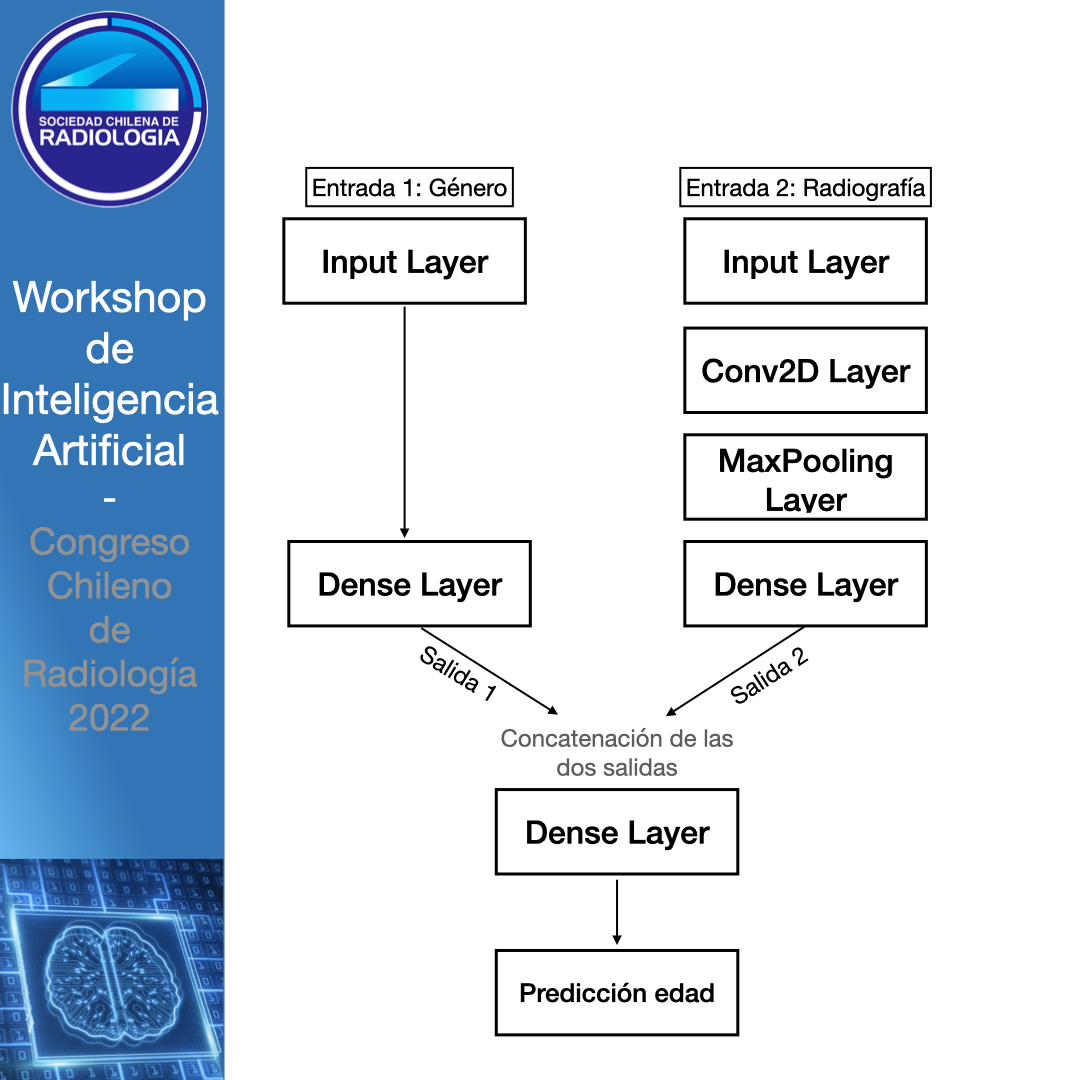

# Hiperparámetros
Para entender este concepto es importante conocer que es un "parámetro" de un modelo. Los parámetros corresponden a valores que definen al modelo, los cuales son aprendidos en el proceso de entrenamiento del mismo. Sin embargo, los hiperparámetros corresponden en palabras simples a la "configuración del modelo" estos, no son aprendidos en el proceso de entrenamiento y deben ser definidos a priori. Distintos hiperparámetros resultarán en diferentes resultados en el rendimiento del modelo. Por lo anterior existen estrategias para probar distintos hiperparámetros, las cuales no tocaremos en este tutorial. Sin embargo puedes probar modificando los hiperparámetros definidos más abajo y ver como cambian los resultados de tu red neuronal 

In [17]:
## Definicion hiperparametros

### El Learning rate corresponde a con cuanta "velocidad" iremos modificando los pesos de la red a medida que se van ajustando
### durante el proceso de entrenamiento
LR = 0.001

### Las épocas corresponden a cuantas veces le entregaremos la totalidad los datos a la red neuronal para ser entrenada
EPOCHS = 15

### El batch size corresponde a en cuantos "paquetes de imágenes" le iremos entregando las imágenes a la red neuronal
### durante cada una de las epocas, hasta haber entregado la totalidad de las imágenes
BATCH_SIZE = 128  ## no superar los 128 debido a limites de memoria

### Dividimos un conjunto de validación de las imágenes para optimizar los hiperparámetros
VAL_SPLIT = 0.1

### El número de neuronas es un hiperparámetros y podemos porbar distintas configuraciones para evaluar el rendimiento del modelo
NEURONAS_CLASIFICADOR = 32

### El drop out es une técnica de regularización para evitar el sobreajuste donde vamos apagando neuronas del modelo
### Una analogía es como un deportista al cual para mejorar su rendimiento en una carrea de atletismo se pone más dificultades al entrenar
### Por ejemplo colocandose más pesos durante el entrenamiento para que cuando corra en la comepetencia le sea más facil
DROP_OUT = 0.1

# Entrenamiento de la red
Para realizar la tarea de clasificacion utilizaremos una arquitectura llamada "Inception". Esta es una entre muchas arquitecturas, las cuales han ido evolucionando con el tiempo para lograr mejores resultados, idealmente con menos datos. Revisa esate link si quieres saber más de esta red neuronal. También te invitamos a explorar otras arquitecturas para que puedas tener un idea general de la variedad que se ha ido generando con el tiempo. 
https://paperswithcode.com/method/inception-v3.

En este tutorial como deseamos utilizar dos tipos de información, es decir la imágenes pero también el genero de un paciente, lo que vamos a hacer será entrenar dos modelos para cada una de las modalidades y luego "unirlos" o "concatenar" ambas informaciones.

Cuando corras este código podrás ver como la consola irá imprimiento el número de épocas que ha completado la red. Si corrieras esté código en tu computador local, probablemente tardaría mucho por que el poder de procesamiento computacional que requieren las redes para no tardar demasiado es muy alto. Por lo anterior utilizamos colab de google, que nos permite usar el poder de computo de sus servidores.

Además podrás ir viendo el cálculo de "Loss" o función de pérdida, es decir una medida que permite calcular la diferencia entre las predicciones que realiza la red y los valores reales. A medida que la red se va entrenando esperamos que este valor se vaya haciendo cada vez más pequeño.

In [18]:
## Se utiliza arquitectura InceptionV3 desde Keras
## No se incluyen los pesos, ya que los pesos de ImageNet funcionan con imagenes en color.
## No se incluye "top", ya que re entrenaremos la capa de clasificación para nuestro problema.

#################################################################################
## Primer Modelo Convolucional para las imagenes.

base_model = InceptionV3(weights= None, include_top=False, input_shape=(data.shape[1],
                                                                       data.shape[2],1))

### Seteamos algunos hiperparámetros adicionales y definimos capas de la red neuronal
x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Flatten()(x1)
x1 = Dense(NEURONAS_CLASIFICADOR, activation='relu')(x1)
x1 = Dropout(DROP_OUT)(x1)
x1 = Dense(1, activation='linear')(x1)

x1 = Model(inputs=base_model.input, outputs=x1)

## Se definen todas las capas entrenables
for layer in base_model.layers:
    layer.trainable = True
################################################################################

################################################################################
## Segundo Modelo que aceptara variables clínicas: Genero

inputGender = Input(shape=(1,))
x2 = Dense(1, activation="relu")(inputGender)
x2 = Model(inputs=inputGender, outputs=x2)
################################################################################

################################################################################
################################################################################
# Se crea una capa de concatenación para los dos Modelos
combined = concatenate([x1.output, x2.output])

## La capa de concatenación termina en una capa de Regresión
y = Dense(1, activation="relu", kernel_regularizer=l1(0.000005))(combined)
y = Dense(1, activation="linear")(y)

## Modelo Final tiene 2 input [imagenes + data] y una capa de salida
model = Model(inputs=[x1.input, x2.input], outputs=y)
################################################################################
################################################################################

## Compilado y entrenamiento del Modelo

model.compile(optimizer=Adam(learning_rate=LR), loss='mae')

checkpoint_filepath = '/content/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


history = model.fit(x=[data[X_train], dataClinica['male'][X_train]], 
                    y=dataClinica['boneage'][y_train], 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
					verbose=1, 
                    validation_split = VAL_SPLIT, 
                    callbacks=[model_checkpoint_callback], shuffle=False)

model.load_weights(checkpoint_filepath)

model.save('BoneAgeInceptionModelSOCHRADI.h5')


Epoch 1/15
80/80 [==============================] - 77s 668ms/step - loss: 80.4357 - val_loss: 5099.7266
Epoch 2/15
80/80 [==============================] - 46s 580ms/step - loss: 32.9656 - val_loss: 39.0488
Epoch 3/15
80/80 [==============================] - 47s 585ms/step - loss: 29.3040 - val_loss: 32.9976
Epoch 4/15
80/80 [==============================] - 45s 569ms/step - loss: 26.9848 - val_loss: 45.0395
Epoch 5/15
80/80 [==============================] - 46s 572ms/step - loss: 23.9898 - val_loss: 42.4869
Epoch 6/15
80/80 [==============================] - 46s 573ms/step - loss: 22.4738 - val_loss: 35.7375
Epoch 7/15
80/80 [==============================] - 46s 571ms/step - loss: 21.4876 - val_loss: 65.6506
Epoch 8/15
80/80 [==============================] - 46s 572ms/step - loss: 20.5776 - val_loss: 68.1740
Epoch 9/15
80/80 [==============================] - 47s 588ms/step - loss: 19.5845 - val_loss: 48.3587
Epoch 10/15
80/80 [==============================] - 47s 586ms/step - l

## Gráfico de la función de pérdida
Una forma interesante de ver como se va entrenando la red neuronal es por medio de graficar los valores de la función de pérdida a medida que van transcurriendo las épocas.

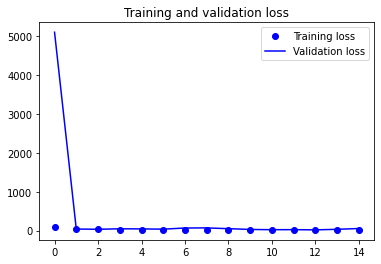

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluación del modelo
Una vez que nuestro modelo ya está entrenado, ya estamos listos para poder testearlo en el conjunto de testeo. De este modo sabremos que tan bien "entendió" la estructura de los datos.

In [20]:
## Evaluación del Modelo en los datos de test:

model.evaluate([data[X_test], dataClinica['male'][X_test]], dataClinica['boneage'][y_test])

40/40 [==============================] - 4s 72ms/step - loss: 18.3865


18.38645362854004

Con el siguiente código de más abajo visualizaremos el resultado en un dato individual

caso Test: 1
Prediccion Modelo:[[11.543378]] años
Edad real del paciente: 11.0 años
Diferencia de edad: [[0.5433782]] años


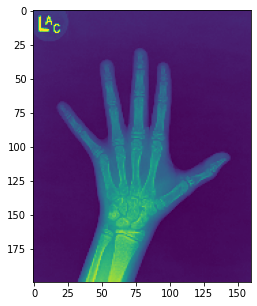

In [25]:

numero = np.random.randint(0, data[X_test].shape[0])
### Si quieres evaluar una imágen en particular puedes descomentar la siguiente línea
#numero = 1

print('caso Test:', numero)

img = data[X_test][numero]
img_tensor = np.expand_dims(img, axis=0) 

genero = dataClinica['male'][y_test].iloc[numero]
genero = np.array(genero)
genero = np.expand_dims(genero, axis=0) 

edad = dataClinica['boneage'][y_test].iloc[numero]

### Este código es muy importante porque aquí predeciremos el valor en el conjunto de testeo
prediccion = model.predict([img_tensor,genero])

print('Prediccion Modelo:{} años'.format(prediccion/12))
print('Edad real del paciente: {} años'.format(edad/12))
print('Diferencia de edad: {} años'.format(abs(edad-prediccion)/12))
plt.figure(figsize=(5,5))

### Existen muchos cmap "o mapas de colores" para visualizar las imágenes 
### por ejemplo podrías probar 
plt.imshow(img_tensor.reshape(200,160), cmap='viridis') 
plt.show()

### Carga de Modelo Pre - entrenado
Como entrenar un modelo puede tomar bastante tiempo, también tenemos la opción de una vez que entrenamos un modelo, guardar la información de los parámetros que obtuvimos. Posteriormente podemos descargar directamente este modelo entrenado para su uso en el futuro. Esto es muy útil porque en internet podremos encontrar muchos modelos ya entrenados para desempeñar diferentes tareas, como por ejemplo la clasificación de radiografías de tórax, de forma muy rápida.

#### Descargue el modelo pre entrenado InceptionV3 desde el link de google Drive o directamente desde Kaggle

https://drive.google.com/drive/folders/1_Ae7S1Z6qCxHEf-uQYi9nUhgesSeGs-e?usp=sharing

In [26]:
## Descargamos Modelo Pre entrenado

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download hshenriquez/bone-age-pretrained-model

!unzip /content/bone-age-pretrained-model.zip

 99% 248M/250M [00:04<00:00, 54.2MB/s]
100% 250M/250M [00:04<00:00, 53.1MB/s]
Archive:  /content/bone-age-pretrained-model.zip
  inflating: BoneAgeInceptionModel160x200v21-06.h5  


In [27]:
modelPretrained =  load_model('/content/BoneAgeInceptionModel160x200v21-06.h5')

El siguiente código imprime toda la información importante del modelo.
Puedes ver por ejemplo el número de capas, el número de neuronas, los tipos de normalización utilizadas, el número de capas convolucionales, las funciones de activación entre otras. Si quieres profundizar más te invitamos a buscar cada uno de tus conceptos para ir comprendiendo de mejor manera el funcionamiento de una red neuronal.

En especial, te invitamos a ir hasta el final de este resumen y que veas el número de parámetros que tiene esta red neuronal. ¿A qué crees que se refiere con parámetros no entrenables? 

In [28]:
## resumen de la arquiectura del modelo cargado
print(modelPretrained.summary())

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 200, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1034 (Conv2D)           (None, 99, 79, 32)   288         ['input_23[0][0]']               
                                                                                                  
 batch_normalization_1034 (Batc  (None, 99, 79, 32)  96          ['conv2d_1034[0][0]']            
 hNormalization)                                                                                  
                                                                                           

## Evaluando el Modelo
Nuevamente testearemos el modelo que ya está entrenando. ¿Existen diferencias entre los resultados que obtuviste y los resultados del modelo pre entrenado? ¿Por qué crees que puede pasar esto?

In [29]:
## rendimiento general del Modelo

modelPretrained.evaluate([data[X_test], dataClinica['male'][X_test]], dataClinica['boneage'][y_test])

40/40 [==============================] - 4s 55ms/step - loss: 10.9771


10.977147102355957

In [ ]:
## Bland - Altman
y_pred = modelPretrained.predict([data[X_test], dataClinica['male'][X_test]])

y_pred = y_pred.reshape(y_pred.shape[0],)

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred, dataClinica['boneage'][y_test] , ax = ax)
plt.show()

### Comparacion de subgrupos
También podemos analizar el rendimiento del modelo en subgrupos determinados y evaluar si se comporta de igual manera para todos o si quizás hay grupos donde se desempeña mejor o peor que en otros.

* Sexo
* Grupos etarios

In [ ]:
### Evaluacion pacientes masculinos
df_test = dataClinica.iloc[X_test]

modelPretrained.evaluate([data[X_test[df_test['male'] == True]], dataClinica['male'][X_test[df_test['male'] == True]]], 
                         dataClinica['boneage'][X_test[df_test['male'] == True]])

In [ ]:
### Evaluacion pacientes femeninas

modelPretrained.evaluate([data[X_test[df_test['male'] == False]], dataClinica['male'][X_test[df_test['male'] == False]]], 
                         dataClinica['boneage'][X_test[df_test['male'] == False]])

## Probando el modelo final
Ya estamos listo para evaluar el modelo final a partir del modelo que descargaste de forma pre entrenada !

In [ ]:

numero = np.random.randint(0, data[X_test].shape[0])
print('caso Test:', numero)

img = data[X_test][numero]
img_tensor = np.expand_dims(img, axis=0) 

genero = dataClinica['male'][y_test].iloc[numero]
genero = np.array(genero)
genero = np.expand_dims(genero, axis=0) 

edad = dataClinica['boneage'][y_test].iloc[numero]

prediccion = modelPretrained.predict([img_tensor,genero])

print('Predicción Modelo:{} años'.format(prediccion/12))
print('Edad ósea del paciente: {} años'.format(edad/12))
print('Diferencia de edad: {} años'.format(abs(edad-prediccion)/12))
plt.figure(figsize=(7,7))
plt.imshow(img_tensor.reshape(200,160), cmap='gray')
plt.show()